## TPU-speed data pipelines


**Learning Objectives**

1. To use the tf.data.Dataset API to load training data.
2. To use TFRecord format to load training data efficiently from GCS.

## Introduction

TPUs are very fast. The stream of training data must keep up with their training speed. In this lab, you will learn how to load data from GCS with the tf.data.Dataset API to feed your TPU.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/tpu_speed_data_pipelines.ipynb).

### Import necessary libraries

In [5]:
import os, re, time, json
import sys, math
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.4


In [6]:
#@title visualization utilities
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  for validation_digits, validation_labels in validation_dataset:
    validation_digits = validation_digits.numpy()
    validation_labels = validation_labels.numpy()
    break
  for training_digits, training_labels in batch_train_ds:
    training_digits = training_digits.numpy()
    training_labels = training_labels.numpy()
    break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### TPU or GPU detection

In [7]:
try: # detect TPUs
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of accelerators:  1


### Parameters

In [8]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) input pipelines with tf.data.Dataset

In [10]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000)
    return dataset

# instantiate the training_dataset and validation_dataset
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)


### Let's have a look at the data

2022-06-13 14:53:56.388471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-13 14:53:57.147916: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-13 14:53:57.808635: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` inste

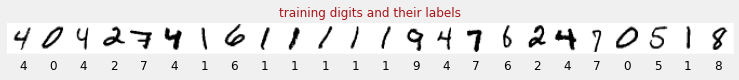

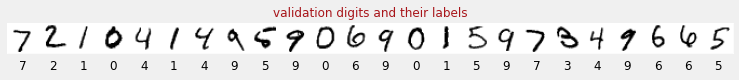

In [11]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 convolutional layers, 2 dense layers
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [12]:
# This model trains to 99.4% accuracy in 10 epochs (with a batch size of 64)  

def make_model():
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
     # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    return model
    
with strategy.scope():
    model = make_model()

# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (Reshape)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0

### Train and validate the model

In [13]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
  
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1,
                    callbacks=[lr_decay])

Steps per epoch:  937
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.


2022-06-13 14:57:06.772411: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9607

2022-06-13 14:57:59.139345: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 55s 54ms/step - loss: 0.1285 - accuracy: 0.9607 - val_loss: 0.0364 - val_accuracy: 0.9870
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.006.
937/937 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9857

2022-06-13 14:58:46.077824: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 45s 48ms/step - loss: 0.0487 - accuracy: 0.9857 - val_loss: 0.0348 - val_accuracy: 0.9886
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0036.
937/937 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9903

2022-06-13 14:59:32.541497: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 46s 50ms/step - loss: 0.0306 - accuracy: 0.9903 - val_loss: 0.0270 - val_accuracy: 0.9917
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0021599999999999996.
936/937 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9935

2022-06-13 15:00:18.447632: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 46s 49ms/step - loss: 0.0203 - accuracy: 0.9935 - val_loss: 0.0230 - val_accuracy: 0.9929
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.001296.
937/937 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9962

2022-06-13 15:01:09.236421: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 51s 54ms/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0224 - val_accuracy: 0.9927
Epoch 6/10

Epoch 00006: LearningRateScheduler setting learning rate to 0.0007775999999999998.
937/937 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9972

2022-06-13 15:01:56.363166: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 47s 50ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 0.0184 - val_accuracy: 0.9938
Epoch 7/10

Epoch 00007: LearningRateScheduler setting learning rate to 0.0004665599999999999.
937/937 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9981

2022-06-13 15:02:44.720567: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 48s 52ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0182 - val_accuracy: 0.9936
Epoch 8/10

Epoch 00008: LearningRateScheduler setting learning rate to 0.00027993599999999994.
937/937 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9985

2022-06-13 15:03:31.361054: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 47s 50ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0176 - val_accuracy: 0.9942
Epoch 9/10

Epoch 00009: LearningRateScheduler setting learning rate to 0.00016796159999999993.
936/937 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

2022-06-13 15:04:15.835424: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 44s 47ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0171 - val_accuracy: 0.9945
Epoch 10/10

Epoch 00010: LearningRateScheduler setting learning rate to 0.00010077695999999997.
936/937 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9988

2022-06-13 15:05:04.938528: W tensorflow/core/framework/dataset.cc:679] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


937/937 [==============================] - 49s 52ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.0169 - val_accuracy: 0.9946


### Visualize predictions

2022-06-13 15:05:05.770171: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_22362"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 24
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Auto

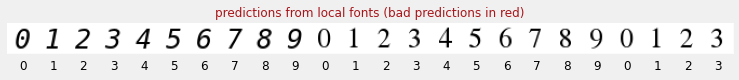

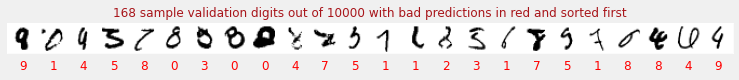

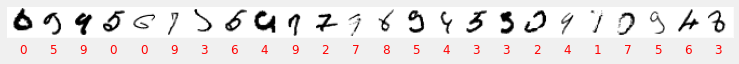

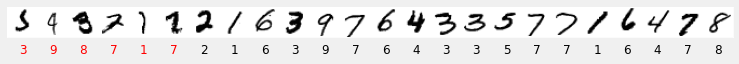

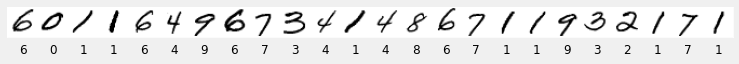

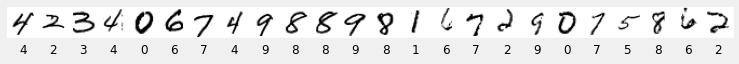

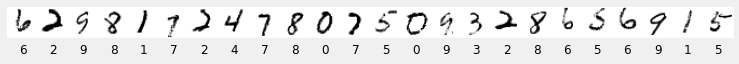

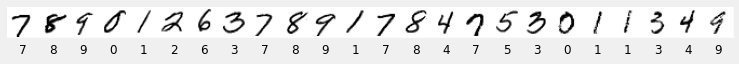

In [14]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

In [15]:
#@title "display utilities"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Configuration

In [16]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # flower labels (folder names in the data)

## Read images and labels
1. Use `fileset=`[`tf.data.Dataset.list_files`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) to scan the data folder
1. Iterate through the dataset of filenames: `for filename in fileset:...` . 
 * Does it work ? Yes, but if you print the filename you get Tensors containing strings.
 * To display the string only, you can use filename.numpy(). This works on any Tensorflow tensor.
 * tip: to limit the size of the dataset for display, you can use [`Dataset.take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Like this: `for data in dataset.take(10): ....`
1. Use [`tf.data.Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to decode the JPEG files. You will find useful TF code snippets below.
 * Iterate on the image dataset. You can use .numpy().shape to only see the data sizes.
  * Are all images of the same size ?
1. Now create a training dataset: you have images but you also need labels:
 *  the labels (flower names) are the directory names. You will find useful TF code snippets below for parsing them.
 * If you do "`return image, label`" in the decoding function, you will have a Dataset of pairs (image, label).
1. You can see the flowers and their labels with the `display_9_images_from_dataset` function. It expects the Dataset to have `(image, label)` elements.

Pattern matches 3670 images.
gs://flowers-public/roses/475936554_a2b38aaa8e.jpg
gs://flowers-public/dandelion/138132145_782763b84f_m.jpg
gs://flowers-public/dandelion/17821459748_873101edd0_m.jpg
gs://flowers-public/dandelion/17574213074_f5416afd84.jpg
gs://flowers-public/tulips/3990989735_59e2751151_n.jpg
gs://flowers-public/dandelion/2693136371_dde2570813.jpg
gs://flowers-public/dandelion/8735646181_fa9787d4e0.jpg
gs://flowers-public/dandelion/5875763050_82f32f2eed_m.jpg
gs://flowers-public/daisy/13583238844_573df2de8e_m.jpg
gs://flowers-public/sunflowers/6606815161_3c4372760f.jpg
(213, 320, 3)
(235, 500, 3)
(284, 320, 3)
(333, 500, 3)
(333, 500, 3)
(248, 320, 3)
(335, 500, 3)
(240, 320, 3)
(240, 240, 3)
(213, 320, 3)
(240, 320, 3) sunflowers
(332, 500, 3) dandelion
(243, 500, 3) roses
(236, 320, 3) roses
(240, 240, 3) tulips
(333, 500, 3) tulips
(329, 500, 3) roses
(281, 500, 3) dandelion
(333, 500, 3) tulips
(221, 240, 3) dandelion


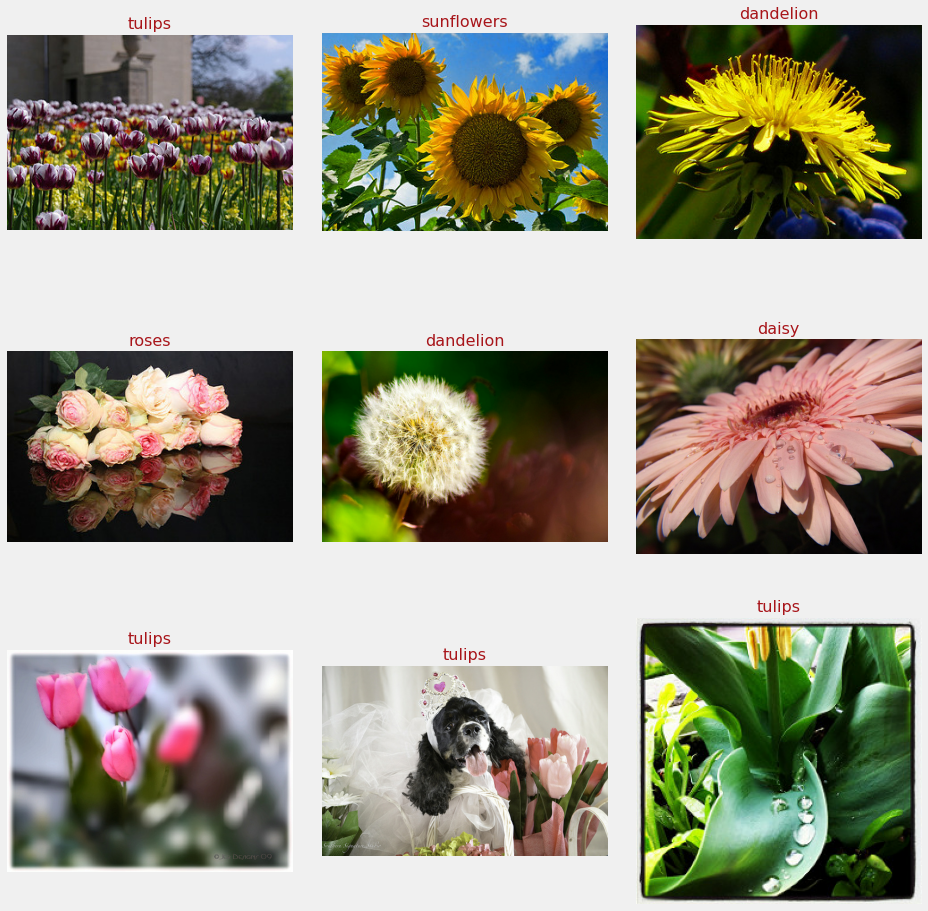

In [17]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
print("Pattern matches {} images.".format(nb_images))

### QUESTIONS 1. and 2.
# TODO
filenames_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
for filename in filenames_dataset.take(10):
  print(filename.numpy().decode('utf-8'))
  
### QUESTION 3.

# copy-pasted from "useful code snippets" below
def decode_jpeg(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  return image

# TODO
image_dataset = filenames_dataset.map(decode_jpeg)
for image in image_dataset.take(10):
  print(image.numpy().shape)
  
### QUESTION 4.

# copy-pasted from "useful code snippets" below
# TODO
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

dataset = filenames_dataset.map(decode_jpeg_and_label)
for image, label in dataset.take(10):
  print(image.numpy().shape, label.numpy().decode('utf-8'))

  ### QUESTION 5.
# TODO
display_9_images_from_dataset(dataset)

## Useful code snippets

### Decode a JPEG in Tensorflow

In [18]:
def decode_jpeg(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  return image

### Decode a JPEG and extract folder name in Tensorflow

In [19]:
def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

In [20]:
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

## Configuration

In [21]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

In [22]:
#@title "display utilities "
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Read images and labels

In [23]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=35155) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.


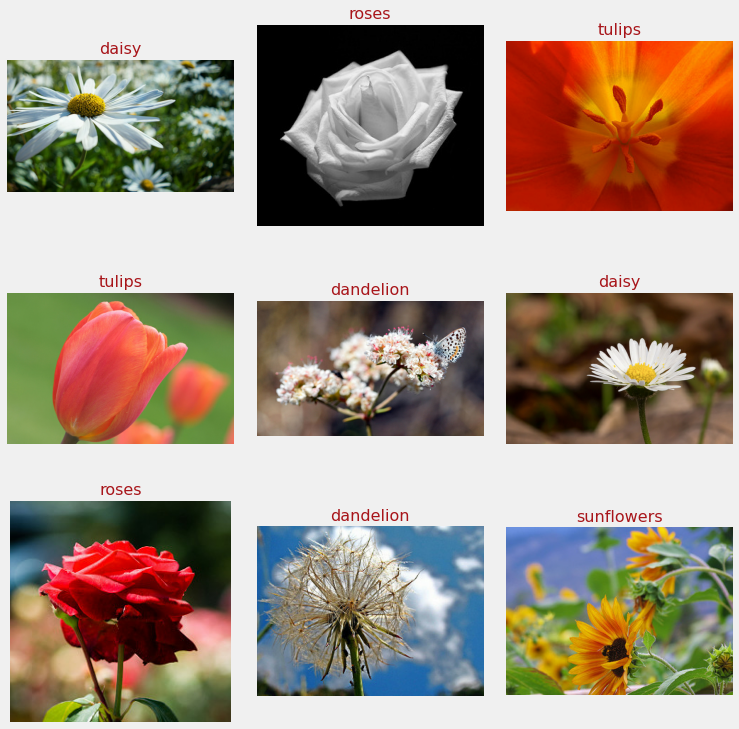

In [24]:
display_9_images_from_dataset(dataset1)

## Resize and crop images to common size
No need to study the code in this cell. It's only image resizing.

In [25]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

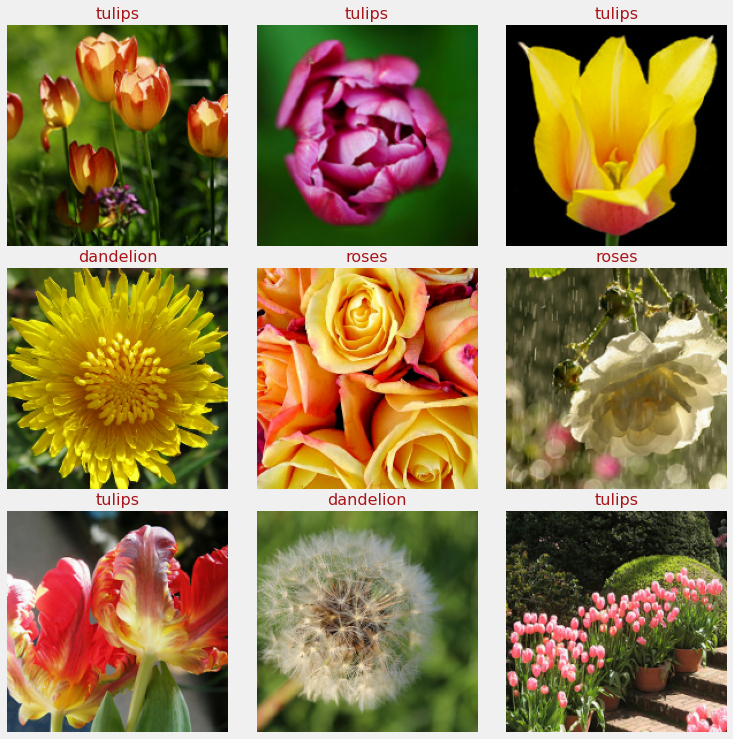

In [26]:
display_9_images_from_dataset(dataset2)

### Speed test: too slow
Google Cloud Storage is capable of great throughput but has a per-file access penalty. Run the cell below and see that throughput is around 8 images per second. That is too slow. Training on thousands of individual files will not work. We have to use the **TFRecord** format to group files together. 

In [27]:
display_dataset = dataset2.batch(8)
for image, label in display_dataset.take(30):
  print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['sunflowers', 'tulips', 'tulips', 'tulips', 'sunflowers', 'tulips', 'tulips', 'daisy'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'daisy', 'dandelion', 'roses', 'dandelion', 'roses', 'roses', 'roses'])
Image batch shape (8, 192, 192, 3), ['daisy', 'daisy', 'tulips', 'daisy', 'tulips', 'daisy', 'sunflowers', 'daisy'])
Image batch shape (8, 192, 192, 3), ['daisy', 'roses', 'sunflowers', 'tulips', 'tulips', 'roses', 'daisy', 'daisy'])
Image batch shape (8, 192, 192, 3), ['roses', 'dandelion', 'roses', 'tulips', 'daisy', 'tulips', 'roses', 'tulips'])
Image batch shape (8, 192, 192, 3), ['daisy', 'dandelion', 'tulips', 'tulips', 'dandelion', 'tulips', 'roses', 'daisy'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'sunflowers', 'sunflowers', 'roses', 'daisy', 'dandelion', 'daisy', 'roses'])
Image batch shape (8, 192, 192, 3), ['roses', 'roses', 'sunflowers', 'daisy', 'sunflowers', 'daisy', 'roses', 'roses'])
Image batch shape (8, 192, 192, 3

## Recompress the images
The bandwidth savings outweight the decoding CPU cost

In [28]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

## Write dataset to TFRecord files
**Do not run the below cell, just read through.**

**You do not have write access to the output bucket so you would get an error. Read through the code to familiarize yourself with TFRecord encoding.**

In [29]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()) # variable length  list of floats, n=len(CLASSES)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file gs://flowers-public/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records


PermissionDeniedError: Error executing an HTTP request: HTTP response code 403 with body '{
  "error": {
    "code": 403,
    "message": "546103917682-compute@developer.gserviceaccount.com does not have storage.objects.create access to the Google Cloud Storage bucket.",
    "errors": [
      {
        "message": "546103917682-compute@developer.gserviceaccount.com does not have storage.objects.create access to the Google Cloud Storage bucket.",
        "domain": "global",
        "reason": "forbidden"
      }
    ]
  }
}
'
	 when initiating an upload to gs://flowers-public/tfrecords-jpeg-192x192-2/flowers00-230.tfrec

## Read  from TFRecord Dataset
**Resume running the cells**

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
# TODO
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

In [ ]:
display_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))
display_9_images_from_dataset(display_dataset)

### Speed test: fast
Loading training data is not a bottleneck anymore

In [ ]:
for image, class_num, label, height, width, one_hot_class in dataset4.take(300):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num, label.numpy().decode('utf8'), one_hot_class))